In [0]:
from __future__ import print_function, division

import torch
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

plt.ion()   # interactive mode

In [ ]:
# If you work in google colab you can upload data to your google drive and mount it to colab
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# The path for the project folder in your google drive
# os.chdir('drive/My Drive/project')

In [ ]:
# I you use colab, you should upload archive (zip) of processed data and extract it here
# !unzip data/asl_alphabet.zip -d data/

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.join(os.getcwd(), 'data', 'asl_alphabet')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

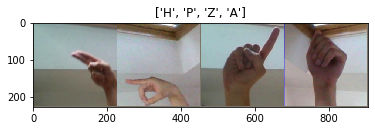

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
if not os.path.exists('weights'):
    os.mkdir('weights')

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = np.Inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('\t{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc >= best_acc and epoch_loss <= best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                weights_file_path = os.path.join('weights', f'asl_recognition__{epoch}.pt')
                torch.save(best_model_wts, weights_file_path)
                print(f'Saved to "{weights_file_path}"')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
device

device(type='cuda')

In [14]:
# Load pretrained GoogLeNet model
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features

# reinit its last layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:02<00:00, 17.9MB/s]


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

  0%|          | 0/20928 [00:00<?, ?it/s]

Epoch 1/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0056 Acc: 0.9992


100%|██████████| 829/829 [00:18<00:00, 44.51it/s]


	test Loss: 0.0005 Acc: 0.9997


  0%|          | 0/20928 [00:00<?, ?it/s]

Saved to "asl_recognition_0.pt"

Epoch 2/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0056 Acc: 0.9993


  0%|          | 0/20928 [00:00<?, ?it/s]

	test Loss: 0.0005 Acc: 0.9997
Saved to "asl_recognition_1.pt"

Epoch 3/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0052 Acc: 0.9994


  0%|          | 0/20928 [00:00<?, ?it/s]

	test Loss: 0.0002 Acc: 1.0000
Saved to "asl_recognition_2.pt"

Epoch 4/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0049 Acc: 0.9993


  0%|          | 0/20928 [00:00<?, ?it/s]

	test Loss: 0.0004 Acc: 1.0000

Epoch 5/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0052 Acc: 0.9994


  0%|          | 0/20928 [00:00<?, ?it/s]

	test Loss: 0.0004 Acc: 1.0000

Epoch 6/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0056 Acc: 0.9992


  0%|          | 0/20928 [00:00<?, ?it/s]

	test Loss: 0.0003 Acc: 1.0000

Epoch 7/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0051 Acc: 0.9994


  0%|          | 0/20928 [00:00<?, ?it/s]

	test Loss: 0.0003 Acc: 1.0000

Epoch 8/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0050 Acc: 0.9994


  0%|          | 0/20928 [00:00<?, ?it/s]

	test Loss: 0.0003 Acc: 1.0000

Epoch 9/10
----------


  0%|          | 0/829 [00:00<?, ?it/s]

	train Loss: 0.0054 Acc: 0.9993


  0%|          | 0/20928 [00:00<?, ?it/s]

	test Loss: 0.0003 Acc: 1.0000

Epoch 10/10
----------


 78%|███████▊  | 16346/20928 [12:05<04:55, 15.48it/s]

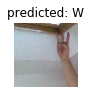

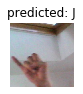

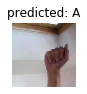

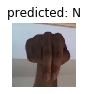

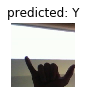

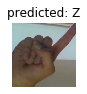

In [16]:
visualize_model(model_ft)

In [0]:
# model_ft.load_state_dict(torch.load('weights/asl_recognition__2.pt'))
# model_ft.eval()
# model_ft = model_ft.to(device)